# 5. Walks

Random and kernel walks represent fascinating techniques that have found applications in various fields. Each step of a walk is a consequence of the previous state, creating coherent yet unpredictable progressions. Walks have been embraced by composers and sound artists to wander through new territories of algorithmic music. Iannis Xenakis, a composer and architect, is perhaps one of the most renowned composers to integrate random processes, including random walks, into his compositions. Works like [Mikka](https://www.youtube.com/watch?v=Ifxs3TBSSAs) and [Epeï](https://www.youtube.com/watch?v=8ZP3TbLtfq4) are seminal examples where randomized methods contribute to the structural foundation of the music. Karlheinz Stockhausen and his work with controlled randomness and serial techniques also touch upon concepts akin to random walks. His compositions, such as [Klavierstück XI](https://www.youtube.com/watch?v=mMDdihXI98A), employ a form of controlled chance that dictates the sequence of musical events, offering a multitude of possible paths through the piece.

The application of random walks in music composition involves generating sequences of musical elements, usually pitches and sequences, where each element is selected based on a combination of random choice and a set of rules or conditions influenced by previous elements. This approach allows composers to explore new forms of musical structure and texture, creating pieces that can vary greatly with each performance or realization while maintaining an underlying coherence.

In this section, we will also cover *kernel walks*, an innovative technique akin to random walks. This approach dig into well-known statistical objects named Gaussian processes to generate randomly oscillating paths. Most interestingly, kernel walks can be forced to pass through predefined points, and create melodies wandering around predefined progressions.

## Random walks

A random walk is a mathematical process where each step is a random choice relative to the one preceeding it. Mathematician call them Markov chains, named after mathematician Andrey Markov. The random choice can be as simple as a coin flip: if it goes tail, you take a diagional step left. Heads, a diagonal step on right. Repeat the process over and over and you obtain a random walk. On average, you should walk ahead, but in fact, you'll probably derive from a straight path. The concept of randomness was introduced in [Minimalism](04_minimalism.html), but we didn't really dig in its meaning. 

### Understanding randomness

A mathematical function using a probability distribution is named a *stochastic* function. The concept of randomness is often misunderstood. It's not about everything being possible without constraints. When we talk about selecting a random number, the process is not as open-ended as it might seem. When you flip a coin, its either heads or tails (or, rarely, the edge...). 

Randomness is structured by probability distributions, a collection of mathematical functions structuring randomness and approximate processes underlying a reality too complex to be perfectly predictable. The coin toss is a binomial distribution: it's either true or false. Another familiar example is the Normal distribution, known for its bell-shaped curve. When we sample from this distribution, values near the mean (center of the curve) are more likely to occur than those far from it, say, more than 4 units away or less than -4 units from the mean. The Normal distribution is characterized by two parameters: the mean, which locates the center of the curve, and the standard deviation, which determines the width of the curve. The height of a population can have a mean and a standard deviation.

There are numerous probability distributions, catering to different types of data. Continuous values, for instance, are often modelled using the Normal distribution, but also uniform distributions, where the likelihood of selecting any number within a specified range is exactly the same. This means that every number has an equal chance of being chosen, ensuring a flat distribution of probabilities across the entire range. Discrete data, such as categorical outcomes in music genres, can be represented by the multinomial distribution, which is described by a set of probabilities summing to 1. The Poisson distribution produces integer, useful for counting occurrences. Mathematicians have been working on probability distributions for centuries, and are still creating new ones, and exploring fascinating properties of existing ones.

Understanding these distributions helps in contextualizing randomness, especially in creative domains like music, where generating random rhythms involves selecting from a defined range of possibilities according to a specific probability distribution. This structured approach to randomness allows for the generation of diverse and interesting rhythmic patterns within a coherent framework.

In [1]:
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np
import scipy

# Normal distribution
x_norm = np.linspace(-4, 4, 100)
y_norm = scipy.stats.norm.pdf(x_norm, 0, 1)  # normal distribution with 0 mean and 1 standard deviation

# Uniform distribution
x_unif = np.linspace(-4, 4, 100)
y_unif = scipy.stats.uniform.pdf(x_unif, -1, 2) # uniform distribution from -1, spanning 2

# Multinomial distribution
n = 10
categories = ['Folk', 'Classic', 'Punk rock', 'Jazz']
p = [0.15, 0.30, 0.10, 0.45]

# Poisson distribution
mu = 3
y_poisson = scipy.stats.poisson.pmf(np.arange(10), mu)  # distribution de Poisson

# Figure
fig = sp.make_subplots(rows=1, cols=4)
fig.add_trace(go.Scatter(x=x_norm, y=y_norm, mode='lines'), row=1, col=1)
fig.update_xaxes(title_text="Normal distribution", row=1, col=1)
fig.add_trace(go.Scatter(x=x_unif, y=y_unif, mode='lines'), row=1, col=2)
fig.update_xaxes(title_text="Uniform distribution", row=1, col=2)
fig.add_trace(go.Bar(x=categories, y=p), row=1, col=3)
fig.update_xaxes(title_text="Multinomial distribution", row=1, col=3)
fig.add_trace(go.Bar(x=np.arange(10), y=y_poisson), row=1, col=4)
fig.update_xaxes(title_text="Poisson distribution", row=1, col=4)
fig.update_layout(showlegend=False, template='none')

fig.write_image("_images/probability-distributions.png")

<img src="_images/probability-distributions.png" alt="probability distributions" />

### Logic of the random walk

Random walks are available in Djalgo in file `walk.py`. From there, there are two options to generate walks. The first one, `Chain`, is a classic random walk, and the second, `Kernel`, is Gaussian processes generator, which will be discussed later in this section.

The random walk generator takes several of arguments. The `walk_range` argument takes a list of the minimum and maximum numbers to confine the walk (to create a *bounded* random walk). For instance, if you aim at restraining the walk between -10 and 10, you would enter `walk_range=[-10, 10]`. The `walk_probability` can take a list of numbers, for instance `[-1, 0, 1]` if you aim at generating steps of -1, 0 and 1. It can also take a [Scipy probability distribution](https://docs.scipy.org/doc/scipy/reference/stats.html) function, for instance `scipy.stats.norm(loc=0, scale=1)`, where `loc` and `scale` are the mean and the standard deviation. The `length` argument specifies the number of steps. The `round_to` argument, with default `None`, rounds stepping to a given decimal.

Djalgo has the ability to randomly branch a walk. When a walk is branched, a new walk is created and wanders on it own. The probability to branch is specified from 0 to 1 in the `branching_probability` argument. Conversely, `merging_probability` is the probability to merge random walks when they collide. If `round_to` is not triggered on, there is virtually no chance that branches collide.

### Example



I'd like to generate a random walk through pitches from `C2` to `C8`, starting at `C4`. MIDI pitch numbers can be recovered using Djalgo's abc_to_midi utility function.

In [2]:
import djalgo as dj
print('C2:', dj.utils.abc_to_midi('C2'))
print('C4:', dj.utils.abc_to_midi('C4'))
print('C8:', dj.utils.abc_to_midi('C8'))

C2: 36
C4: 60
C8: 108


The random walk will be conducted between numbers 36 to 108 through 20 steps, starting at 60. Through the walk, each step will branch with a probability of 0.1 and when branches fall to the same pitch, they will merge with a probability of 0.9.

In [3]:
rw = dj.walk.Chain(
    walk_range=[36, 108], walk_start=60, walk_probability=scipy.stats.norm(loc=0, scale=2),
    length=20, round_to = 0, branching_probability=0.1, merging_probability=0.9
)
rw

The `rw` is a random walk object, which can be used to generate many random walks, although only one will be generated in this example.

In [4]:
rw_sequences = rw.generate(seed=6)
len(rw_sequences)

9

`rw_sequences` contains 5 branches. If you examine the object, you will see lists beginning with `None` values, which are generated when a new branch is created to make sure all branches are generated with the same length. At each step, if branching returns `True` with probability `branching_probability`, a new list is created, and the random walk becomes a list of lists, and all values of the new list happening before the branch are set to `None`. Each branch then has its own random walk, and can branch out. If two or more branch collide to the same values, and if merging if `True` according to probability `merging_probability`, lists are closed with `None` values to the following notes, except the branch with the lower index, on which the other branches are merged. The merged branch continues the random walk, and can branch again.

In [5]:
import plotly.graph_objects as go
fig = go.Figure()
for i, seq in enumerate(rw_sequences):
    fig.add_trace(go.Scatter(
        x=[i for i, val in enumerate(seq) if val is not None],
        y=[val for val in seq if val is not None],
        mode='lines'
    ))
fig.update_layout(showlegend=False)
fig.write_image("_images/chain-walk-example.png")

<img src="_images/chain-walk-example.png" alt="plot of the result of the chain-walk example">

We can map pitches to durations by creating a rhythm for each track.

In [6]:
index_quarter_length = 1.0  # Length of a quarter note in the random walk index
measure_length = 4  # Duration of each measure
rw_notes = []
rhythm_durations = [ # the same number of sets as len(rw_sequences)
    [0.125, 0.25, 0.5, 1, 2],
    [1, 2],
    [1, 2],
    [1, 1, 2],
    [0.5, 1, 2],
    [0.5, 1],
    [0.5, 0.5, 1],
    [0.25, 0.5, 1, 2],
    [0.125, 0.25, 0.5, 1, 2]
]
for seq, random_dur in zip(rw_sequences, rhythm_durations): # zip to the shortest length
    rhythm = dj.rhythm.Rhythm(measure_length=measure_length, durations=random_dur).random(seed=6)
    dur = [r[0] for r in rhythm]
    iso = dj.rhythm.isorhythm(pitches=seq, durations=dur)
    rw_notes.append(iso)
#dj.conversion.to_music21(rw_notes).show()
dj.conversion.to_music21(rw_notes).show('midi')

The notes wander on the chromatic scale. To provide a little structure to a walk, we can wander through indexes of a scale list rather than on notes.

In [7]:
g_major = dj.harmony.Scale('G', 'major').generate()[39:53]
# [dj.utils.midi_to_abc(p) for p in g_major] # used to adjust the range fro 39 to 53
rw_index = dj.walk.Chain(
    walk_range=[0, len(g_major)-1],
    walk_start=7, # the seventh index on the scale
    walk_probability=scipy.stats.norm(loc=0, scale=2),
    length=30, round_to = 0, branching_probability=0.05, merging_probability=0.9
).generate(seed=1)
len(rw_index)

7

Seven tracks have been generated. I can generate different rhythms from draws from a single list. I set the seed at the beginning of the block, and not in the `.random()` method to make sure that rhythms are not the same for all tracks, but remains the same each time I run the block. Setting seed is very useful to assures that random processes provide the same results, hence avoid losing an interesting pattern because it was random and can't be recovered.

In [8]:
import random
random.seed(123)
measure_length = 3
rw_notes_tuned = []
for seq in rw_index:
    rhythm = dj.rhythm.Rhythm(measure_length=measure_length, durations=[0.5, 1, 2]).random()
    d = [r[0] for r in rhythm]
    p = [g_major[int(index)] for index in seq if index is not None]
    iso = dj.rhythm.isorhythm(
        pitches=p,
        durations=d
    )
    rw_notes_tuned.append(iso)
dj.conversion.to_music21(rw_notes_tuned).show('midi')

## Gaussian Processes

A normal distribution is a mathematically elegant way of describing the average and variance (or standard deviation, an index of diversity) among a population. We can stack as many normal distributions as the amount of variables describing a population, for example age, height and weight of people in Canada. When we think that our variables are linked to one another, like height, weight and age, we can merge normal distributions together in a single multivariate normal distribution. Such distribution is described by a vector of 3 means and a 3×3 covariance matrix, a squared matrix with variances on the diagonal and pairwise covariances between variables elsewhere, describing the strength of the link between variables. There is no limit on the amount of variables in the multivariate normal. For example, day after day, you measure air temperature hourly, at 7:00, 8:00, 9:00, etc. You will have one normal distribution of temperature at 7:00 for all days of the week, one at 8:00, etc. Since the temperature at hours closed to each other are likely correlated, you might use a multivariate normal. And because the correlation between temperatures will slowly vanish for distant measurements, you could use a function to describe the correlation. Such function will reveal to be useful if you narrow the time steps. For instance, if you record the temperature at each second, you will have a large amount of variables, thus a long mean vector and an extended covariance matrix. To go even further, since time is continuous, our multivariate normal will contain an infinity of dimensions. A multivariate normal distribution with infinite number of dimensions is called a Gaussian process.

To allow infinite dimensions, and compute probabilities at any dimension, the mean vector and the covariance matrix must be described by functions. The mean function is usually ruled out of the equation since it can be dealt by setting it to constant zero, then offsetting the end result by the mean, for instance a pitch of 60, the midi number representing the center C on the keyboard of a piano. This is why Gaussian processes are mostly described by the covariance function, also called the *kernel*. Samples from a normal or a multivariate normal distribution are points. Samples from a Gaussian process, because they are continuous, are functions.

These functions can be used just as we used random walks. So why bothering with abstract mathematical concepts if you could just use a random walk function? Because Gaussian processes carry very interesting properties. You might indeed have heard of Gaussian processes as a machine learning method. This means that they can be fitted to data. To perform such fitting task, the Scikit-Learn library should be installed though.

In this section, I will introduce you to the use of unfitted and fitted Gaussian processes to generate music.

### *Unfitted* Gaussian Processes

Unfitted Gaussian processes are only described by their kernel. Random samples from a kernel will create a pattern for music to follow. As any translational music practice, many music attributes can be generated. However, I will keep my focus on notes.

For unfitted GPs, the covariance function is created but Djalgo's `rbf_kernel` function, as known as the kernel, with two properties.

- The `length_scale` parameter describes the inertia of the covariance. Larger lengths create longer waves.
- The multiplier of the kernel, often refered as $\alpha$ in textbooks, describes the `amplitude` of the wave.

The following plot was generated from `djalgo.walk.Kernel`.

In [9]:
# Building a dict filled with kernel responses for varying amplitude and length scale
length = 100
n_samples = 3
kernel_walks = {'d': [], 'sample': [], 'x': [], 'y': []}
for ls in [0.1, 1., 10., 100.]:
    for amp in [0.1, 1., 10.]:
        for s in range(n_samples):
            kernel_walks['d'].extend(['ls: ' + str(ls) + ', a: ' + str(amp)]*length)
            kernel_walks['sample'].extend(['sample: ' + str(s)]*length)
            kernel_walks['x'].extend(list(range(length)))
            kernel_walks['y'].extend(
                dj.walk.Kernel(
                    walk_around=0.0,
                    length=length,
                    length_scale=ls,
                    amplitude=amp
                ).generate()[0]
            )

import plotly.express as px
fig = (
    px.line(kernel_walks, x='x', y='y', color='sample', facet_col='d', facet_col_wrap=3)
    .update_layout(autosize=False, width=800, height=800)
)
fig.write_image("_images/kernels-example.png")

<img src='_images/kernels-example.png' alt='plot of the effects of amplitude and length scale on kernel response'>

Just like random walks, the signal of a Gaussian process can be transformed to really anything: pitches, scale indices, durations, MIDI channel, etc. Let's use it here to generate scale indices from the following list.

In [10]:
b_blues_scale = dj.harmony.Scale('B', [0, 3, 5, 6, 7, 10, 12]).generate()[29:42]
print([dj.utils.midi_to_abc(p) for p in b_blues_scale]) # used to adjust the range fro 28 to 42
scale_length = len(b_blues_scale)

['B3', 'D4', 'E4', 'F4', 'F#4', 'A4', 'B4', 'D5', 'E5', 'F5', 'F#5', 'A5', 'B5']


The next block does three things. First, the `dj.walk.Kernel` generates a number of `ntracks` samples from a Gaussian process. As for the second part, because the numbers generated are indexes and not pitches, the `for` loops, needs them to be integer values between (included) 0 to the rank of the last index of the scale we want to pick pitches from. Finally, the tracks are plotted. Plots are useful to calibrate `amplitude` and `length_scale`. Different combinations of `amplitude` and `length_scale` were tried to obtain signals that are sufficiently wavy in the x direction (length scale) and ranging through the indexes allowed in the scale list. 

In [11]:
# Extract 3 samples of length 8 from a GP
length = 8
ntracks = 3
blues_tracks_i = dj.walk.Kernel(
    walk_around=4, # sixth index
    length=length,
    length_scale=1.0,
    amplitude=5.0
).generate(nsamples=ntracks, seed=1)

# blues_tracks_i are list indexes. I must make sure that indexes are integer and between the range og the scale list
for t in range(ntracks):
    for i in range(length):
        blues_tracks_i[t][i] = int(round(blues_tracks_i[t][i]))
        if blues_tracks_i[t][i] > scale_length-1:
            blues_tracks_i[t][i] = scale_length-1
        elif blues_tracks_i[t][i] < 0:
            blues_tracks_i[t][i] = 0

# Plot the tracks
import plotly.graph_objects as go
fig = go.Figure()
for i,track in enumerate(blues_tracks_i):
    fig.add_trace(go.Scatter(x=list(range(length)), y=track, mode='lines', name='Signal ' + str(i)))
fig.update_layout(
    xaxis=dict(title='Time (quarter notes)'), yaxis=dict(title='Scale index'),
    autosize=False, width=800, height=400
)
fig.write_image("_images/gp-blues-tracks.png")

<img src="_images/gp-blues-tracks.png" alt="plot of blues tracks">

The following comprehensive list extracts the pitches from the scale for each track to create chords.

> I use intensively inline for loops. I founded them very confusing at first, but I have never been able to do without it since I understood how they worked.

In [12]:
blues_track_chords = [[b_blues_scale[blues_tracks_i[t][i]] for t in range(ntracks)] for i in range(length)]
blues_track_chords

[[66, 76, 66],
 [59, 69, 71],
 [59, 64, 74],
 [64, 59, 66],
 [59, 64, 65],
 [59, 69, 66],
 [59, 66, 65],
 [59, 64, 66]]

The first chord plays pitch 66 twice. We could create a function to scan and remove them, but here it's simpler to manually alter the pitch to None.

In [13]:
blues_track_chords[0][2] = None

Rhythms are generated randomly.

In [14]:
blues_rhythm = dj.rhythm.Rhythm(durations=(0.25, 0.5, 1, 2, 4), measure_length=4).random(seed=2)
print(blues_rhythm)

[(0.25, 0.0), (1, 0.25), (1, 1.25), (0.5, 2.25), (0.5, 2.75), (0.25, 3.25), (0.5, 3.5)]


Finally, isorhythms are applied to generateone track of chords.

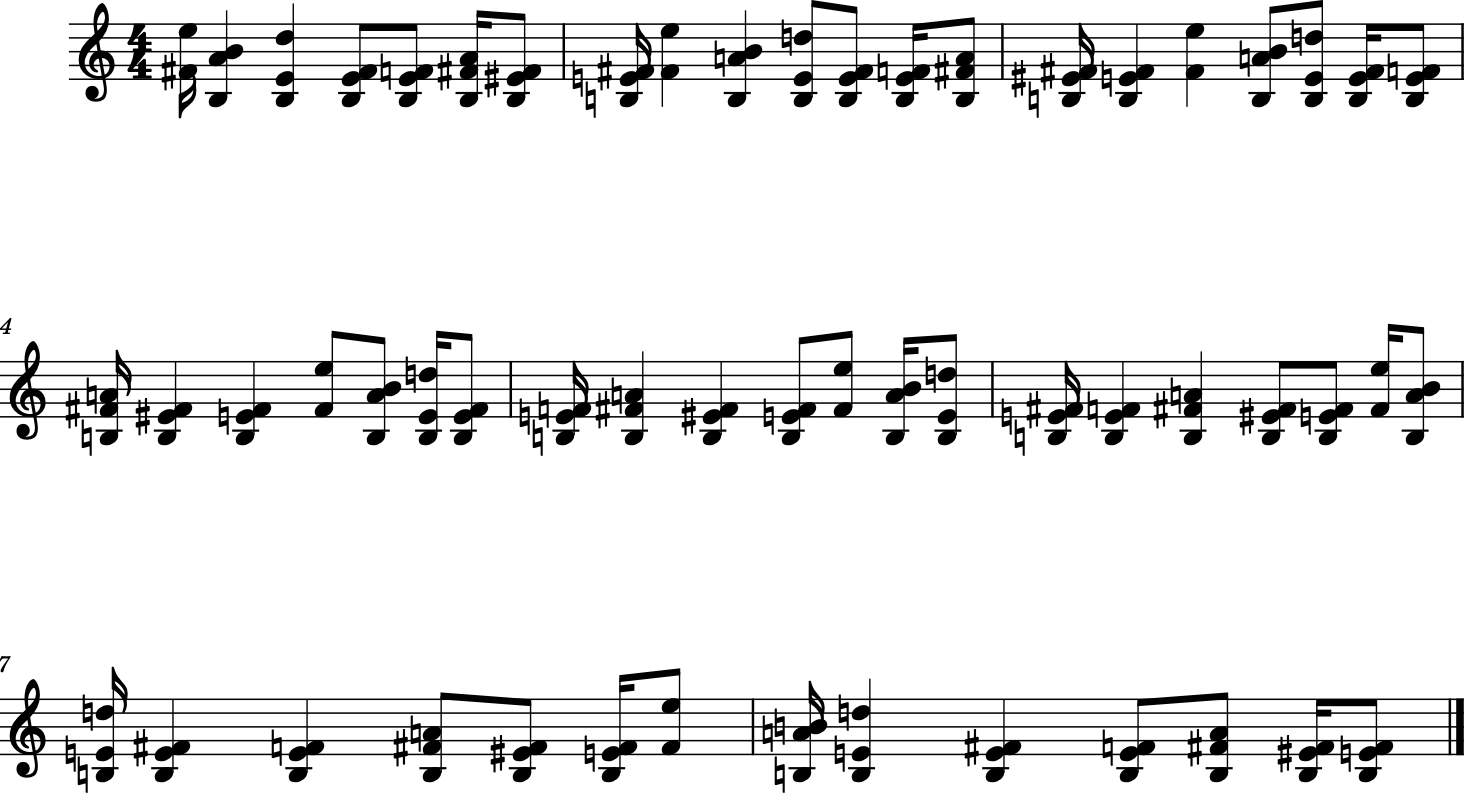

In [15]:
blues_track = dj.rhythm.isorhythm(pitches=blues_track_chords, durations=[r[0] for r in blues_rhythm])
blues_track_m21 = dj.conversion.convert(blues_track, to='music21')
blues_track_m21.show()
blues_track_m21.show('midi')

### *Fitted* Gaussian Processes

One very interesting aspect of multivariate normal distributions is that they can be conditioned at will. Let's recover our multivariate normal describing age, height and weight. The distribution of heights and weights *given* that age is between 32 years old is still a multivariate normal, but now in 2D rather than 3D. Just like we can condition multivariate normal, we can condition Gaussian processes with known data. When a Gaussian process is fitted on, for instance, temperature, the fundamental question you ask as the modeller is what function the temperature might have followed. A fitted Gaussian process can generate as many of such functions as you require, so you end up with a distribution of functions. The question can be asked similarly for a musical score: what variations be extracted from a constrained pattern? Djalgo doesn't require Scikit-Learn to work, but its installation is required for fitted Gaussian processes.

```
!pip install scikit-learn
```

An interest question to ask: what variations be extracted from Pachelbel's progression?

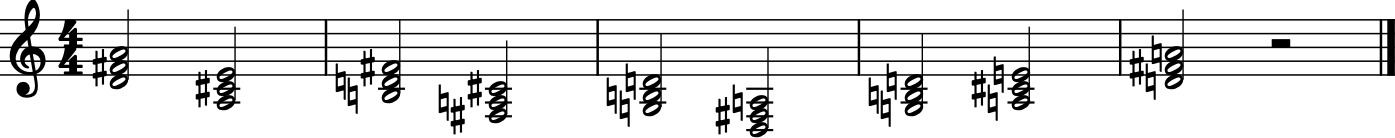

In [16]:
# Define the scale
d_major = dj.harmony.Scale('D', 'major').generate()

# Find the pitches
pachelbel_progression_abc = ['D4', 'A3', 'B3', 'F#3', 'G3', 'D3', 'G3', 'A3', 'D4'] # looping, so I include final D4
pachelbel_progression_p = [dj.utils.abc_to_midi(p) for p in pachelbel_progression_abc]

# Find the chors in d_major
pachelbel_progression_c = []
for p in pachelbel_progression_p:
    pachelbel_progression_c.append([p, d_major[d_major.index(p) + 2], d_major[d_major.index(p) + 4]])

# Assemble it to Djalgo's format, then export to Music21
pachelbel_durations = [2] * len(pachelbel_progression_c)
pachelbel_progression_iso = dj.rhythm.isorhythm(pitches=pachelbel_progression_c, durations=pachelbel_durations)
pachelbel_progression_m21 = dj.conversion.convert(pachelbel_progression_iso, to='music21')
pachelbel_progression_m21.show()
pachelbel_progression_m21.show('midi')

```{Note}
The code under `# Find the chors in d_major` is really helpful to add *voicing* to a progression.
```

We printed the chords, but our constrained will really be pitch indexes of the fundamentals. To model this, we add a `data` argument to our `djalgo.walk.Kernel` object in the form of a Numpy array with time (offset) in the first column, and pitch index in the second

In [17]:
import numpy as np
data = np.array([
    [note[2] for note in pachelbel_progression_iso],
    [d_major.index(note[0][0]) for note in pachelbel_progression_iso]
]).T
data

array([[ 0, 36],
       [ 2, 33],
       [ 4, 34],
       [ 6, 31],
       [ 8, 32],
       [10, 29],
       [12, 32],
       [14, 33],
       [16, 36]])

When data are provided, Djalgo interpolates a number of `length` data points on the range of the data, fits the model, then export results in time and model predictions.

In [27]:
ntracks = 3
length = 100
pachelbel_tracks_pt = dj.walk.Kernel(
    length=length,
    length_scale=0.5,
    amplitude=1
).generate(data=data, nsamples=ntracks, seed=10)
pachelbel_tracks_t = pachelbel_tracks_pt[0]
pachelbel_tracks_p = pachelbel_tracks_pt[1]

In [28]:
fig = go.Figure()
for i,track in enumerate(pachelbel_tracks_p):
    fig.add_trace(go.Scatter(x=pachelbel_tracks_t, y=track, mode='lines', name='Signal ' + str(i)))
fig.add_trace(go.Scatter(x=data[:, 0], y=data[:, 1], mode='markers', name='data'))
fig.write_image("_images/pachelbel-tracks.png")

<img src="_images/pachelbel-tracks.png" alt="plot of the pachelbel tracks">

If you are interested in Scikit-learn, and would like more flexibility, this is what Djalgo does under the hood.

```
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF
    x = np.linspace(0, self.data[:, 0].max(), self.length)[:, np.newaxis]
    kernel = self.amplitude * RBF(length_scale=self.length_scale) # , length_scale_bounds = (self.length_scale*0.9, self.length_scale*1.1)
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10)
    gp.fit(data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1))
    sequence = [
        x.flatten().tolist(),
        gp.sample_y(x, n_samples=nsamples).T.tolist()
    ]
```

We can extract the exact index value at every time using linear interpolation with Numpy.

In [29]:
np.interp(3.5, pachelbel_tracks_t, pachelbel_tracks_p[0])

35.240185022580484

So, for each track, let's create a random rhythm, interpolate indexes to the offsets, find the indexes on the `d_major` scale, and assemble the tracks.

In [30]:
import random
random.seed(10)
tracks = []
for i in range(ntracks):
    rythm = dj.rhythm.Rhythm(durations=[0.25, 0.5, 1, 2], measure_length=8).random() * 2
    pitch_index = np.interp(
        x=[r[1] for r in rythm],
        xp=pachelbel_tracks_t,
        fp=pachelbel_tracks_p[i]
    )
    pitch_index = np.round(pitch_index).astype(int).tolist()
    notes = []
    for j,r in zip(pitch_index, rythm):
        notes.append((
            d_major[j], r[0], r[1]
        ))
    tracks.append(notes)

We can offset the tracks to create a cannon. The result is a reinterpretation of Pachelbel's Cannon in D-major.

In [31]:
tracks[0] = dj.utils.offset_list_of_notes(tracks[0], by=1)
tracks[1] = dj.utils.offset_list_of_notes(tracks[1], by=2)
tracks[2] = dj.utils.offset_list_of_notes(tracks[2], by=3)
tracks.append(pachelbel_progression_iso)
dj.conversion.convert(tracks, to='music21').show('midi')